<a href="https://colab.research.google.com/github/COTILab/MCX24Workshop/blob/master/MCX2024_2A_mmc_training.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!#@title <font color='orange'>Init 1: Initial setup of environment for running MCXLAB (run the below section once)</font>

# install octave and oct2py
! sudo apt-get update && sudo apt-get install octave jq libpocl2 pocl-opencl-icd    # install octave (a free matlab clone)
! pip install oct2py jdata bjdata matplotlib   # install oct2py, jdata, bjdata and matplotlib Python modules
#!apt-get install nvidia-opencl-icd-384        # optional: install nvidia OpenCL(+2min), needed for mmc/mmclab demos later

# add octave support to colab notebook
%load_ext oct2py.ipython

# download and unzip mcxlab
! rm -rf mcxlab*
! wget https://mcx.space/nightly/release/MCX24/MCXStudio-linux-x86_64-nightlybuild.zip  # download MCX suite
! unzip -o MCXStudio-linux-x86_64-nightlybuild.zip && rm -rf MCXStudio-linux-x86_64-nightlybuild.zip # unzip MCX suite

# add executable to the shell's paths
! sudo cp -a $PWD/MCXStudio/MCXSuite/mcx/bin/mcx /usr/local/bin
! sudo cp -a $PWD/MCXStudio/MCXSuite/mcxcl/bin/mcxcl /usr/local/bin
! sudo cp -a $PWD/MCXStudio/MCXSuite/mmc/bin/mmc /usr/local/bin
! cp -a $PWD/MCXStudio/MATLAB/zmat/octave/gnu-linux-x86_64/zipmat.mex $PWD/MCXStudio/MATLAB/zmat/

# if a GPU runtime can not be allocated, run this section to setup OpenCL and MCXLAB-CL
! [[ ! -f `which nvidia-smi` ]] && sudo mv /usr/local/bin/mcxcl /usr/local/bin/mcx
! mcx -L

In [95]:
%%octave
addpath([pwd filesep 'MCXStudio/MATLAB/mcxlab']);                 % add path to mcxlab
addpath([pwd filesep 'MCXStudio/MCXSuite/mcx' filesep 'utils']);  % add path to mcx helper functions
addpath([pwd filesep 'MCXStudio/MATLAB/mmclab']);                 % add path to mmclab
addpath([pwd filesep 'MCXStudio/MCXSuite/mmc' filesep 'matlab']); % add path to mmc helper functions
addpath([pwd filesep 'MCXStudio/MATLAB/iso2mesh']);               % add path to iso2mesh/jsonlab
addpath([pwd filesep 'MCXStudio/MATLAB/brain2mesh']);             % add path to brain2mesh
addpath([pwd filesep 'MCXStudio/MATLAB/zmat']);                   % add path to zmat for data compression

if(system('which nvidia-smi'))                   % if this runtime does not have NVIDIA GPU support
    addpath([pwd filesep 'MCXStudio/MATLAB/mcxlabcl']);    % add path to mcxlabcl
    USE_MCXCL=1;                                 % set USE_MCXCL flag in the base workspace
end

In [97]:
%%octave
which mcx
which s2m
which zipmat

mcxlab('gpuinfo')     % use this command to list supported CPU or GPU in octave
unix('mcx -L')        % use -L flag to list GPU in the command line

MCXLAB ERROR -35 in unit mcx_core.cu:2564: CUDA driver version is insufficient for CUDA runtime version

'mcx' is a function from the file /content/MCXStudio/MATLAB/mcxlab/mcx.mex

's2m' is a function from the file /content/MCXStudio/MATLAB/iso2mesh/s2m.m

'zipmat' is a function from the file /content/MCXStudio/MATLAB/zmat/zipmat.mex

Oct2PyError: Octave evaluation error:
error: mcxcl: OpenCL is not supported or not fully installed on your system
error: called from:
    mcxlab at line 499, column 36

In [11]:
# @title Install iso2mesh for tetrahedral meshing in octave:

# download and unzip iso2mesh
!git clone https://github.com/fangq/iso2mesh.git


Cloning into 'iso2mesh'...
remote: Enumerating objects: 3589, done.
remote: Counting objects: 100% (554/554), done.
remote: Compressing objects: 100% (317/317), done.
remote: Total 3589 (delta 288), reused 490 (delta 237), pack-reused 3035
Receiving objects: 100% (3589/3589), 125.53 MiB | 33.45 MiB/s, done.
Resolving deltas: 100% (2308/2308), done.


In [12]:
# @title Add octave support to colab notebook (may need to be re-run after crashes)
#Add Octave support

# add octave support to colab notebook
%load_ext oct2py.ipython

The oct2py.ipython extension is already loaded. To reload it, use:
  %reload_ext oct2py.ipython


In [98]:
# @title Add paths in octave (same as adding folders in matlab)
%%octave

addpath(genpath([pwd filesep 'mmc']));                 % add path to mmc

addpath([pwd filesep 'iso2mesh']);                 % add path to iso2mesh

In [99]:
# @title Check installation of different packages in octave
%%octave
% check that mmclab is installed
help mmclab
% check that iso2mesh is installed
help dist2surf

% mmclab('gpuinfo')

'mmclab' is a function from the file /content/MCXStudio/MATLAB/mmclab/mmclab.m

 #############################################################################%

                     Mesh-based Monte Carlo (MMC) - OpenCL                   %

          Copyright (c) 2010-2024 Qianqian Fang <q.fang at neu.edu>          %

              https://mcx.space/#mmc  &  https://neurojson.io/               %

                                                                             %

 Computational Optics & Translational Imaging (COTI) Lab  [http://fanglab.org]%

   Department of Bioengineering, Northeastern University, Boston, MA, USA    %

 #############################################################################%

    The MCX Project is funded by the NIH/NIGMS under grant R01-GM114365      %

 #############################################################################%

  Open-source codes and reusable scientific data are essential for research, %

 MCX proudly developed human-readable JSON-based data formats for easy reuse.%

                                                                             %

 Please visit our free scientific data sharing portal at https://neurojson.io/%

 and consider sharing your public datasets in standardized JSON/JData format %

 #############################################################################%

 $Rev::efc749$v2024.2$Date::2024-06-09 15:58:33 -04$ by $Author::Qianqian Fang%

 #############################################################################%

 Format:

    [fluence,detphoton,ncfg,seeds,traj]=mmclab(cfg);

          or

    fluence=mmclab(cfg);

    newcfg=mmclab(cfg,'prep');

    [fluence,detphoton,ncfg,seeds,traj]=mmclab(cfg, options);

 Input:

    cfg: a struct, or struct array. Each element in cfg defines

         a set of parameters for a simulation.

    option: (optional), options is a string, specifying additional options

         option='preview': this plots the domain configuration using mcxpreview(cfg)

         option='opencl':  force using OpenCL (set cfg.gpuid=1 if not set)

                           instead of SSE on CPUs/GPUs that support OpenCL

    cfg may contain the following fields:

 == Required ==

     *cfg.nphoton:     the total number of photons to be simulated (integer)

     *cfg.prop:        an N by 4 array, each row specifies [mua, mus, g, n] in order.

                       the first row corresponds to medium type 0 which is

                       typically [0 0 1 1]. The second row is type 1, and so on.

     *cfg.node:        node array for the input tetrahedral mesh, 3 columns: (x,y,z)

     *cfg.elem:        element array for the input tetrahedral mesh, 4 columns

     *cfg.elemprop:    element property index for input tetrahedral mesh

     *cfg.tstart:      starting time of the simulation (in seconds)

     *cfg.tstep:       time-gate width of the simulation (in seconds)

     *cfg.tend:        ending time of the simulation (in second)

     *cfg.srcpos:      a 1 by 3 vector, the position of the source in mesh node length unit

     *cfg.srcdir:      if defined as [vx, vy, vy], it specifies the incident vector

                       if defined as [vx, vy, vy, focus], the first 3 elements define

                       the incident vector; focus controls the convergence or

                       divergence of the beam:

                       focus=0: collimated beam

                       focus<0: diverging beam from an imaginary src at c0-|focus|*[vx vy vz]

                       focus>0: converging beam, focusing to a point at c0+|focus|*[vx vy vz]

                       where c0 is the centroid of the source domain. Setting focus does

                       not impact pencil/isotropic/cone sources.

 == MC simulation settings ==

      cfg.seed:        seed for the random number generator (integer)

                       if set to a uint8 array, the binary data in each column is used

                       to seed a photon (i.e. the "replay" mode), default value: 1648335518

      cfg.isreflect:   [1]-consider refractive index mismatch, 0-matched index

                       2 - total absorption on exterior surface

                       3 - prefect reflection (mirror) on exterior surface

      cfg.isnormalized:[1]-normalize the output fluence to unitary source, 0-no reflection

      cfg.isspecular:  [1]-calculate specular reflection if source is outside

      cfg.ismomentum:  [0]-save momentum transfer for each detected photon

      cfg.method:      ray-tracing method, ["plucker"]:Plucker, "havel": Havel (SSE4),

                       "badouel": partial Badouel, "elem": branchless Badouel (SSE),

                       "grid": dual-grid MMC

      cfg.mcmethod:    0 use MCX-styled MC method, 1 use MCML style MC

      cfg.nout:        [1.0] refractive index for medium type 0 (background)

      cfg.minenergy:   terminate photon when weight less than this level (float) [0.0]

      cfg.roulettesize:[10] size of Russian roulette

      cfg.steps:       [dx, dy, dz], defines the DMMC grid voxel size,

                       must be isostropic, i.e. dx=dy=dz, only used when

                       cfg.method = 'grid', by default dx=dy=dz=1

      cfg.unitinmm:    defines the default length unit (to interpret mesh nodes, src/det positions

                       the default value is 1.0 (mm). For example, if the mesh node length unit is

                       in cm, one should set unitinmm to 10.

      cfg.basisorder:  [1]-linear basis, 0-piece-wise constant basis

 == Source-detector parameters ==

      cfg.detpos:      an N by 4 array, each row specifying a detector: [x,y,z,radius]

      cfg.maxdetphoton:   maximum number of photons saved by the detectors [1000000]

      cfg.srctype:     source type, the parameters of the src are specified by cfg.srcparam{1,2}

                      'pencil' - default, pencil beam, no param needed

                      'isotropic' - isotropic source, no param needed

                      'cone' - uniform cone beam, srcparam1(1) is the half-angle in radian

                      'gaussian' - a gaussian beam, srcparam1(1) specifies the waist radius

                                (in default length unit); if one specifies a non-zero focal length

                                using cfg.srcdir, the gaussian beam can be converging to or

                                diverging from the waist center, which is located at srcpos+focus*srcdir;

                                optionally, one can specify the wavelength lambda (in cfg.unitinmm mm),

                                using srcparam1(2). This will rescale the Gaussian profile according

                                to w(z)=w0*sqrt(1-(z/z0)^2), where w0 is the waist radius, z is the

                                distance (in mm) to the waist center (focus), and z0 is the Rayleigh

                                range (in mm), and z0 is related to w0 by z0=w0^2*pi/lambda

                      'planar' - a 3D quadrilateral uniform planar source, with three corners specified

                                by srcpos, srcpos+srcparam1(1:3) and srcpos+srcparam2(1:3)

                      'pattern' - a 3D quadrilateral pattern illumination, same as above, except

                                srcparam1(4) and srcparam2(4) specify the pattern array x/y dimensions,

                                and srcpattern is a floating-point pattern array, with values between [0-1].

                                if cfg.srcnum>1, srcpattern must be a floating-point array with

                                a dimension of [srcnum srcparam1(4) srcparam2(4)]

                                Example: <demo_photon_sharing.m>

                      'fourier' - spatial frequency domain source, similar to 'planar', except

                                the integer parts of srcparam1(4) and srcparam2(4) represent

                                the x/y frequencies; the fraction part of srcparam1(4) multiplies

                                2*pi represents the phase shift (phi0); 1.0 minus the fraction part of

                                srcparam2(4) is the modulation depth (M). Put in equations:

                                    S=0.5*[1+M*cos(2*pi*(fx*x+fy*y)+phi0)], (0<=x,y,M<=1)

                      'arcsine' - similar to isotropic, except the zenith angle is uniform

                                distribution, rather than a sine distribution.

                      'disk' - a uniform disk source pointing along srcdir; the radius is

                               set by srcparam1(1) (in default length unit)

                      'fourierx' - a general Fourier source, the parameters are

                               srcparam1: [v1x,v1y,v1z,|v2|], srcparam2: [kx,ky,phi0,M]

                               normalized vectors satisfy: srcdir cross v1=v2

                               the phase shift is phi0*2*pi

                      'fourierx2d' - a general 2D Fourier basis, parameters

                               srcparam1: [v1x,v1y,v1z,|v2|], srcparam2: [kx,ky,phix,phiy]

                               the phase shift is phi{x,y}*2*pi

                      'zgaussian' - an angular gaussian beam, srcparam1(1) specifies the variance in

                               the zenith angle

      cfg.{srcparam1,srcparam2}: 1x4 vectors, see cfg.srctype for details

      cfg.srcpattern: see cfg.srctype for details

      cfg.srcnum:     the number of source patterns that are

                      simultaneously simulated; only works for 'pattern'

                      source, see cfg.srctype='pattern' for details

                      Example <demo_photon_sharing.m>

      cfg.replaydet:  only works when cfg.outputtype is 'jacobian', 'wl', 'nscat', or 'wp' and cfg.seed is an array

                       0 replay all detectors and sum all Jacobians into one volume

                       a positive number: the index of the detector to replay and obtain Jacobians

      cfg.voidtime:   for wide-field sources, [1]-start timer at launch, 0-when entering

                      the first non-zero voxel

      by default, mmc assumes the mesh and source position settings are all in mm unit.

      if the mesh coordinates/source positions are not in mm unit, one needs to define

      cfg.unitinmm  (in mm) to specify the actual length unit.

 == Optional mesh data ==

     -cfg.facenb:      element face neighbohood list (calculated by faceneighbors())

     -cfg.evol:        element volume (calculated by elemvolume() with iso2mesh)

     -cfg.e0:          the element ID enclosing the source, if not defined,

                       it will be calculated by tsearchn(node,elem,srcpos);

                       if cfg.e0 is set as one of the following characters,

                       mmclab will do an initial ray-tracing and move

                       srcpos to the first intersection to the surface:

                       '>': search along the forward (srcdir) direction

                       '<': search along the backward direction

                       '-': search both directions

 == Output control ==

      cfg.issaveexit: [0]-save the position (x,y,z) and (vx,vy,vz) for a detected photon

      cfg.issaveref:  [0]-save diffuse reflectance/transmittance on the exterior surfaces.

                      The output is stored as flux.dref in a 2D array of size [#Nf,  #time_gate]

                      where #Nf is the number of triangles on the surface; #time_gate is the

                      number of total time gates. To plot the surface diffuse reflectance, the output

                      triangle surface mesh can be extracted by faces=faceneighbors(cfg.elem,'rowmajor');

                      where 'faceneighbors' can be found in the iso2mesh toolbox.

                      Example: see <demo_mmclab_basic.m>

      cfg.issaveseed:  [0]-save the RNG seed for a detected photon so one can replay

      cfg.isatomic:    [1]-use atomic operations for saving fluence, 0-no atomic operations

      cfg.outputtype:  'flux' - output fluence-rate

                       'fluence' - fluence,

                       'energy' - energy deposit,

                       'jacobian' - mua Jacobian (replay mode)

                       'wl'- weighted path lengths to build mua Jacobian (replay mode)

                       'wp'- weighted scattering counts to build mus Jacobian (replay mode)

      cfg.debuglevel:  debug flag string, a subset of [SCBWDIOXATRPEM], no space

      cfg.debugphoton: print the photon movement debug info only for a specified photon ID

      cfg.maxjumpdebug: [10000000|int] when trajectory is requested in the output,

                     use this parameter to set the maximum position stored. By default,

                     only the first 1e6 positions are stored.

      fields marked with * are required; options in [] are the default values

      fields marked with - are calculated if not given (can be faster if precomputed)

    type: omit or 'omp' for multi-threading version; 'sse' for the SSE4 MMC,

          the SSE4 version is about 25% faster, but requires newer CPUs;

          if type='prep' with a single output, mmclab returns ncfg only.

 Output:

      fluence: a struct array, with a length equals to that of cfg.

            For each element of fluence, fluence(i).data is a 2D array with

            dimensions [size(cfg.node,1), total-time-gates] if cfg.basisorder=1,

            or [size(cfg.elem,1), total-time-gates] if cfg.basisorder=0.

            The content of the array is the normalized fluence-rate (or others

            depending on cfg.outputtype) at each mesh node and time-gate.

            If cfg.issaveref is set to 1, fluence(i).dref is not empty, and stores

            the surface diffuse reflectance (normalized by default). The surface mesh

            that the dref output is attached can be obtained by faces=faceneighbors(cfg.elem,'rowmajor');

      detphoton: (optional) a struct array, with a length equals to that of cfg.

            Starting from v2016.5, the detphoton contains the below subfields:

              detphoton.detid: the ID(>0) of the detector that captures the photon

              detphoton.nscat: cummulative scattering event counts in each medium

              detphoton.ppath: cummulative path lengths in each medium (partial pathlength)

                   one need to multiply cfg.unitinmm with ppath to convert it to mm.

              detphoton.mom: cummulative cos_theta for momentum transfer in each medium

              detphoton.p or .v: exit position and direction, when cfg.issaveexit=1

              detphoton.w0: photon initial weight at launch time

              detphoton.prop: optical properties, a copy of cfg.prop

              detphoton.data: a concatenated and transposed array in the order of

                    [detid nscat ppath mom p v w0]'

              "data" is the is the only subfield in all MMCLAB before 2016.5

      ncfg: (optional), if given, mmclab returns the preprocessed cfg structure,

            including the calculated subfields (marked by "-"). This can be

            used in the subsequent simulations to avoid repetitive preprocessing.

      seeds: (optional), if give, mmclab returns the seeds, in the form of

            a byte array (uint8) for each detected photon. The column number

            of seed equals that of detphoton.

      trajectory: (optional), if given, mmclab returns the trajectory data for

            each simulated photon. The output has 6 rows, the meanings are

               id:  1:    index of the photon packet

               pos: 2-4:  x/y/z/ of each trajectory position

                    5:    current photon packet weight

                    6:    enclosing element's ID

            By default, mcxlab only records the first 1e7 positions along all

            simulated photons; change cfg.maxjumpdebug to define a different limit.

 Example:

      cfg.nphoton=1e5;

      [cfg.node face cfg.elem]=meshabox([0 0 0],[60 60 30],6);

      cfg.elemprop=ones(size(cfg.elem,1),1);

      cfg.srcpos=[30 30 0];

      cfg.srcdir=[0 0 1];

      cfg.prop=[0 0 1 1;0.005 1 0 1.37];

      cfg.tstart=0;

      cfg.tend=5e-9;

      cfg.tstep=5e-10;

      cfg.debuglevel='TP';

      % preprocessing to populate the missing fields to save computation

      ncfg=mmclab(cfg,'prep');

      cfgs(1)=ncfg;   % when using struct array input, all fields must be defined

      cfgs(2)=ncfg;

      cfgs(1).isreflect=0;

      cfgs(2).isreflect=1;

      cfgs(2).detpos=[30 20 0 1;30 40 0 1;20 30 1 1;40 30 0 1];

      % calculate the fluence and partial path lengths for the two configurations

      [fluxs,detps]=mmclab(cfgs);

 This function is part of Mesh-based Monte Carlo (MMC) URL: http://mcx.space/#mmc

 License: GNU General Public License version 3, please read LICENSE.txt for details

Additional help for built-in functions and operators is

available in the online version of the manual.  Use the command

'doc <topic>' to search the manual index.

Help and information about Octave is also available on the WWW

at https://www.octave.org and via the help@octave.org

mailing list.

'dist2surf' is a function from the file /content/iso2mesh/dist2surf.m

  [d2surf,cn]=dist2surf(node,nv,p)

  calculate the distances from a point cloud to a surface, and return

  the indices of the closest surface node

  author: Qianqian Fang <q.fang at neu.edu>

  date: 12/12/2008

 parameters:

      node: node coordinate of the surface mesh (nn x 3)

      nv: nodal norms (vector) calculated from nodesurfnorm.m

          with dimensions of (size(node,1),3), this can be

          calcuated from nodesurfnorm.m

      pt: points to be calculated, 3 columns for x,y and z respectively

 outputs:

      d2surf: a vector of length of p, the distances from p(i) to the surface

      cn: a integer vector with the length of p, the indices of the closest surface node

 Please find more information at http://iso2mesh.sf.net/cgi-bin/index.cgi?metch

 this function is part of "metch" toobox, see COPYING for license

Additional help for built-in functions and operators is

available in the online version of the manual.  Use the command

'doc <topic>' to search the manual index.

Help and information about Octave is also available on the WWW

at https://www.octave.org and via the help@octave.org

mailing list.

generating tetrahedral mesh from closed surfaces ...

creating volumetric mesh from a surface mesh ...

volume mesh generation is complete

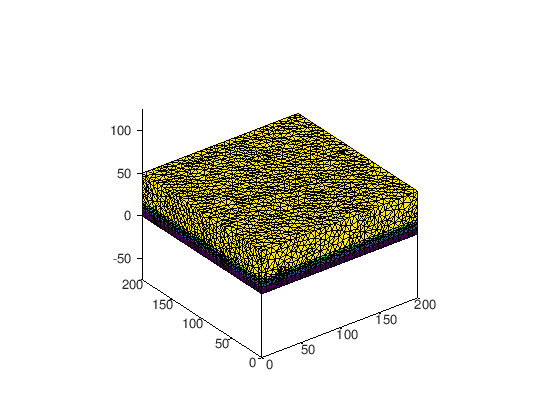

In [21]:
# @title Prepare mesh for slab model of brain

%%octave

addpath(genpath([pwd filesep 'mmc']));                 % add path to mmc
addpath([pwd filesep 'iso2mesh']);                 % add path to iso2mesh

% thickness of each layer in mm
TN=[7.25,4.00,2.73,3.29,4.23];

% prepare simulation mesh (a five layered slab):

% prepares a surface-only mesh:
[nodes,faces]=latticegrid([0 200],[0 200],[0 7.25 11.25 13.98 17.27 50]);
[nodes,faces]=latticegrid([0 200],[0 200],[0 TN(1,1) sum(TN(1,1:2)) sum(TN(1,1:3)) sum(TN(1,1:4)) 50]);

% plot the surface mesh to verify it is correct
%plotmesh(nodes, faces);

% prepares interior tetrahedrons for that mesh:
% max_volume is very important and determines our mesh density
% dramatically impacts performance:
max_volume = 100;

[nodes,elems]=surf2mesh(nodes,faces,[],[],1,max_volume,[1 1 4;1 1 9;1 1 12;1 1 14.5;1 1 25]);

% plot the tetrahedral mesh to verify it is correct:
plotmesh(nodes, elems);

% save the mesh values:
save -mat7-binary layered_slab nodes elems;

refining the input mesh ...

Opening /tmp/pre_refine.1.node.

Opening /tmp/pre_refine.1.ele.

Opening /tmp/pre_refine.1.vol.

Reconstructing mesh.

Mesh reconstruction seconds:  0.552237

Repairing mesh.

Repair seconds:  0.016911

Adding Steiner points to enforce quality.

Quality seconds:  0.500976

Optimizing mesh.

Optimize seconds:  0.101818

Writing /tmp/pre_refine.2.node.

Writing /tmp/pre_refine.2.ele.

Writing /tmp/pre_refine.2.face.

Output seconds:  0.183867

Total running seconds:  1.35768

Statistics:

  Input points: 15334

  Input tetrahedra: 87021

  Mesh points: 18972

  Mesh tetrahedra: 109020

  Mesh triangles: 221581

  Mesh subfaces: 29518

  Mesh subsegments: 987

mesh refinement is complete

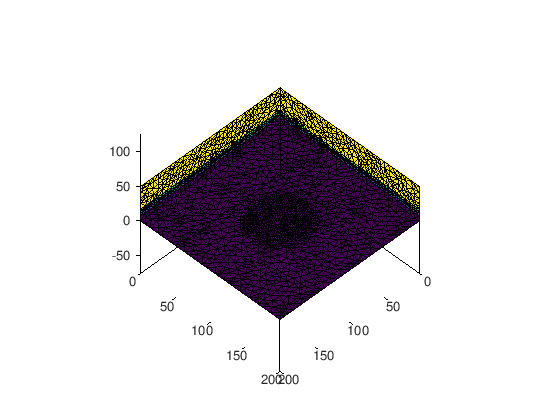

In [64]:
# @title Refine Tetrahedron sizes near the source
# this may be necessary when you are plotting near the source or want higher spatial resolution for fluence near the source (or any other feature)
# prevents performance issues from an otherwise large domain

%%octave

addpath(genpath([pwd filesep 'mmc']));                 % add path to mmc
addpath([pwd filesep 'iso2mesh']);                 % add path to iso2mesh


load('layered_slab');
centroids = meshcentroid(nodes, elems(:,1:4));

% set maxvols to a large value by default
% to later set smaller values for specific elements
maxvols = ones(size(elems,1),1)*10000;
% refine the size of tetrahedrons near the source if desired (not necessary in DMMC):
for i=1:size(elems,1)

    % Get elem centroid distance from source
    Dist = norm([centroids(i,:).-[100,100,0]], 2);
    dist(i) = Dist;
    % Refine elements based on distance to source
    if Dist<38
        maxvols(i)=4;
    elseif Dist<20
        maxvols(i)=2;
    end
end

% this command selectively refines (splits into smaller tetrahedrons)
% all the tetrahedrons based on the maxvols sizes.
[new_nodes, new_elems] = meshrefine(nodes, elems, maxvols);

plotmesh(new_nodes, new_elems);
view(-45, -45);

% save new mesh values:
nodes = new_nodes;
elems = new_elems;
save -mat7-binary layered_slab nodes elems;

In [100]:
# @title Prepare MMC simulation config
%%octave

% load the mesh we prepared earlier
load('layered_slab');

% set the config values to the mesh variables
cfg_mmc.node=nodes;
cfg_mmc.elem=elems;

% set the number of photons
nphotons=1e6;
cfg_mmc.nphoton=nphotons;

% set the random seed
cfg_mmc.seed=1234567;

% set the source position and direction:
cfg_mmc.srcpos=[99.5, 100, 0];
cfg_mmc.srcdir=[0, 0, 1];

% we can plot the source position and direction
% to verify it is in the location on the mesh:
figure;
hold on;
plotmesh(nodes, elems);
quiver3(cfg_mmc.srcpos(1), cfg_mmc.srcpos(2), cfg_mmc.srcpos(3),
        cfg_mmc.srcdir(1), cfg_mmc.srcdir(2), cfg_mmc.srcdir(3), 'MaxHeadSize', 40, 'Color', 'r', 'MarkerFaceColor', 'r');
% change view direction to view the mesh from the zero-side of the z-axis:
view(-47, -45);
cfg_mmc.srctype='pencil';

% we set detector positions then plot them to verify positions:
% the following coordinates set detectors at 20, 25, 30, and 35mm away from the source with a radius of 1.5mm
cfg_mmc.detpos=[99.5, 120, 0, 1.5;
                99.5, 125, 0, 1.5;
                99.5, 130, 0, 1.5;
                99.5, 135, 0, 1.5];
scatter3(cfg_mmc.detpos(1,:), cfg_mmc.detpos(2,:), cfg_mmc.detpos(3,:), 'MarkerEdgeColor', 'b', 'MarkerFaceColor', 'b');

% set the time bounds of the simulation in seconds:
cfg_mmc.tstart=0;
cfg_mmc.tend=5e-9;
cfg_mmc.tstep=5e-9;

% set the medium properties:
% labeling,1-air,2-scalp,3-skull,4-csf,5-gray matter,6-white matter
cfg_mmc.prop=[0,0,1,1;
              0.019, 7.8, 0.89, 1.37;
              0.019, 7.8, 0.89, 1.37;
              0.004, 0.009, 0.89, 1.37;
              0.02, 9.0, 0.89, 1.37;
              0.08, 40.9, 0.84, 1.37];

% this sets up a progress bar and timer
cfg_mmc.debuglevel='TP';

% tells the simulation to calculate boundary reflections
cfg_mmc.isreflect=1;

% ray tracing method, elem is typical for mesh-based simulations,
% but 'grid' option will allow faster dual-grid version, at the cost of
% flexibility in discretization of results.
cfg_mmc.method='elem';

% can choose flux or fluence (flux*tstep) as outputs for time gates.
% there is also energy for energy deposition, and several features for fast
% jacobian calculation using our replay method (https://www.ncbi.nlm.nih.gov/pmc/articles/PMC6179418/)
cfg_mmc.outputtype='fluence';
cfg_mmc.isreoriented=0;

% picks which gpu to run on, by setting ones or zeros.
% if you had three GPUs and you wanted to use all three, you would do:
% cfg_mmc.gpuid='111';
% if you had three GPUs and wanted to use the last two, you would do:
% cfg_mmc.gpuid='011';

cfg_mmc.gpuid='1';

%% run the simulation
flux = mmclab(cfg_mmc);

%% save the resulting data:
save -mat7-binary sim_data flux cfg_mmc;



Oct2PyError: Octave evaluation error:
error: /content/MCXStudio/MATLAB/mmclab/mmc.mex: failed to load: /content/MCXStudio/MATLAB/mmclab/mmc.mex: undefined symbol: __libc_longjmp, version GLIBC_PRIVATE
error: called from:
    mmclab at line 430, column 27

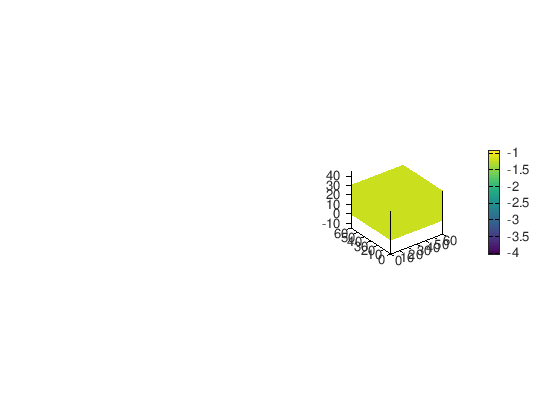

In [ ]:
%%octave

load sim_data

% plot the surface diffuse reflectance
if (isfield(cfg, 'issaveref') && cfg.issaveref == 1)
    subplot(122);
    faces = faceneighbors(cfg.elem, 'rowmajor');
    hs = plotmesh(cfg.node, faces, 'cdata', log10(flux.dref(:, 1)), 'linestyle', 'none');
    colorbar;
end